# Estimate Sobol’ indices for the Ishigami function by a sampling method: a quick start guide to sensitivity analysis

### Analyse de la fonction Ishigami avec l'ensemble de codes dévelopés pour l'analyse de sensibilité sur les cahmps stochastiques.

#### Comparaison et corréctions

La même logique d'écriture de codes est utilisée que dans le script 'Demo Analyse de sensibilité poutre'

In [1]:
# Voici les deux scripts destinés à gérer l'analyse de sensibilité sur les champs stochastiques
import NdGaussianProcessSensitivity as ngps
import NdGaussianProcessConstructor as ngpc
# Classes utilitaires
import numpy                        as np
import openturns                    as ot
import matplotlib.pyplot            as plt
from   importlib                import reload 


In [2]:
# This is the formula used in the openTURNS example. 
formula = ['sin(X1) + 7. * sin(X2)^2 + 0.1 * X3^4 * sin(X1)']
input_names = ['X1', 'X2', 'X3']
g = ot.SymbolicFunction(input_names, formula)

# we have to modifiy the function, be cause it takes as an input a random vector, un-correlated
# in the case of our method, un-correlated inputs are clearly distinct. 

def gMod(X1,X2,X3):
    X = np.stack([X1,X2,X3]).T
    print(X.shape)
    return g(X)

In [3]:
X = np.random.uniform(-np.pi,np.pi,[10,3])
assert gMod(X[...,0], X[...,1], X[...,2]) == g(X) ,""

(10, 3)


Maintenant nous définissons nos variables d'entrée, avec les fonctions contenues dans notre méthode 

In [4]:
reload(ngpc)
reload(ngps)
lower       = -np.pi
upper       = np.pi
nameX1       = 'X1'
nameX2       = 'X2'
nameX3       = 'X3'
RV_X1 = ngpc.UniformDistribution(lower = lower, upper = upper, name = nameX1)
RV_X2 = ngpc.UniformDistribution(lower = lower, upper = upper, name = nameX2)
RV_X3 = ngpc.UniformDistribution(lower = lower, upper = upper, name = nameX3)

In [5]:
# here we have to explicitely define our outputs
outputVariables = {'out1_name' :  #any name here is fine
                   {
                         'name'     : 'Y',
                         'position' : 0,
                         'shape'    : (1,)  
                    },
                  }

In [6]:
inputList = [RV_X1, RV_X2, RV_X3]
soloFunction   = gMod
sampleFunction = gMod
size           = 10000

In [7]:
processSensitivityAnalysis = ngps.NdGaussianProcessSensitivityAnalysis(inputList, 
                                                                       outputVariables,
                                                                       sampleFunction,
                                                                       soloFunction,
                                                                       size)

Input Variables are (without Karhunen Loeve Decomposition) :
 ['X1', 'X2', 'X3'] 

Output Variables are :
 ['Y'] 



In [8]:
processSensitivityAnalysis.prepareSobolIndicesExperiment()

Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)
number of samples for sobol experiment =  50000 

input design is:  [[ 0.81603847  0.84206848 -0.31156285]
 [ 2.40523616 -2.21337969  0.81767286]
 [-2.29162627  2.77812966 -2.25628605]
 ...
 [ 0.23263198 -0.14034356 -2.01157495]
 [-1.81070641  0.97970151 -2.81432234]
 [-2.38135594  1.2781909  -2.44386088]]


In [9]:
processSensitivityAnalysis.getOutputDesignAndPostprocess()

(50000, 3)
Converting list of outputs into matrix: 
Element  1  has shape  (50000, 1)
Final shape matrix:  (50000, 1)
Columns where nan :  [] 


No errors while processing, the function has returned no np.nan.



In [10]:
output = processSensitivityAnalysis.outputDesignList; output1 = output[0]; 

In [11]:
output1

array([[ 4.62496731],
       [ 5.1877794 ],
       [-1.81353077],
       ...,
       [ 0.74498737],
       [-2.23883022],
       [ 3.27048109]])

In [19]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 5)
import NdGaussianProcessSensitivityIndices as ngpsi
_=reload(ngpsi)

Populating the interactive namespace from numpy and matplotlib


In [20]:
S, Stot, varS, varStot = ngpsi.NdGaussianProcessSensitivityIndicesBase.getSobolIndices(output1,10000)

There are 3 indices to get in (1,) dimensions with 1 elements
After centering, mean= [1.17950094e-17] 
std=  [3.6887201]
After centering, mean= [1.17950094e-17] 
std=  [3.6887201]
After centering, mean= [1.17950094e-17] 
std=  [3.6887201]
After centering, mean= [1.49213975e-17] 
std=  [3.6887201]
After centering, mean= [1.49213975e-17] 
std=  [3.6887201]
Indices successfully calculated


The output is scalar
The sensitivity is measured accordingly to the 3 input variables, namely:
 X1 and X2 and X3


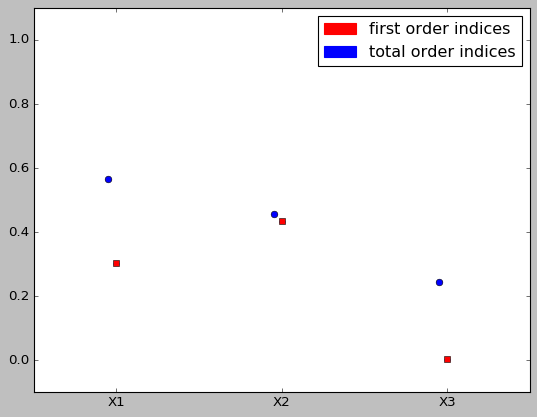

In [22]:
varNames = ['X1', 'X2', 'X3']
ngpsi.plotSobolIndicesWithErr(S, varS, varNames, 3, Stot, varStot)

In [23]:
varS

array([[0.00011246],
       [0.00013583],
       [0.00018026]])